In [1]:
import cv2 as cv
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from mediapipe.python.solutions.pose import PoseLandmark
from mediapipe.python.solutions.drawing_utils import DrawingSpec
import math

In [2]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())


Num GPUs Available:  0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [4]:
def media_pipe_detection(image, model):
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB) 
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv.cvtColor(image, cv.COLOR_RGB2BGR) 
    return image, results

In [5]:
def draw_land_marks(image, results):
    custom_pose_connections = list(mp_pose.POSE_CONNECTIONS)
    
    excluded_landmarks = [
        PoseLandmark.NOSE,
        PoseLandmark.LEFT_EYE_INNER,
        PoseLandmark.LEFT_EYE,
        PoseLandmark.LEFT_EYE_OUTER,
        PoseLandmark.RIGHT_EYE_INNER,
        PoseLandmark.RIGHT_EYE,
        PoseLandmark.RIGHT_EYE_OUTER,
        PoseLandmark.LEFT_EAR,
        PoseLandmark.RIGHT_EAR,
        PoseLandmark.MOUTH_LEFT,
        PoseLandmark.MOUTH_RIGHT,
        PoseLandmark.LEFT_HIP,
        PoseLandmark.RIGHT_HIP,
        PoseLandmark.LEFT_KNEE,
        PoseLandmark.RIGHT_KNEE,
        PoseLandmark.LEFT_ANKLE,
        PoseLandmark.RIGHT_ANKLE,
        PoseLandmark.LEFT_HEEL,
        PoseLandmark.RIGHT_HEEL,
        PoseLandmark.LEFT_FOOT_INDEX,
        PoseLandmark.RIGHT_FOOT_INDEX
    ]

    for landmark in excluded_landmarks:
        custom_pose_connections = [connection_tuple for connection_tuple in custom_pose_connections if landmark.value not in connection_tuple]

    mp_drawing.draw_landmarks(image, results.pose_landmarks, connections=custom_pose_connections)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [6]:
def draw_styled_handmarks(image, results):   
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2),
                             ) 
      
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
     
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [7]:
def extract_keypoints_normalize(results):
    midpoint_shoulder_x, midpoint_shoulder_y = 0, 0
    shoulder_length = 1

    if results.pose_landmarks:
        left_shoulder = results.pose_landmarks.landmark[11]
        right_shoulder = results.pose_landmarks.landmark[12]

        midpoint_shoulder_x = (left_shoulder.x + right_shoulder.x) / 2
        midpoint_shoulder_y = (left_shoulder.y + right_shoulder.y) / 2

        shoulder_length = math.sqrt((left_shoulder.x - right_shoulder.x) ** 2 + (left_shoulder.y - right_shoulder.y) ** 2)

        selected_pose_landmarks = results.pose_landmarks.landmark[11:23]
        pose = np.array([[(res.x - midpoint_shoulder_x) / shoulder_length, 
                          (res.y - midpoint_shoulder_y) / shoulder_length] for res in selected_pose_landmarks]).flatten()
    else:
        pose = np.zeros(22 * 2)

    if results.left_hand_landmarks:
        left_hand = np.array([[(res.x - midpoint_shoulder_x) / shoulder_length, 
                               (res.y - midpoint_shoulder_y) / shoulder_length] for res in results.left_hand_landmarks.landmark]).flatten()
    else:
        left_hand = np.zeros(21 * 2)

    if results.right_hand_landmarks:
        right_hand = np.array([[(res.x - midpoint_shoulder_x) / shoulder_length, 
                                (res.y - midpoint_shoulder_y) / shoulder_length] for res in results.right_hand_landmarks.landmark]).flatten()
    else:
        right_hand = np.zeros(21 * 2)

    return np.concatenate([pose, left_hand, right_hand])

In [8]:
def extract_coordinate(results):
    if results.pose_landmarks:
        selected_pose_landmarks = results.pose_landmarks.landmark[11:23]
        for res in selected_pose_landmarks:
            x = res.x
            y = res.y
            print(f"POSE LANDMARK x: {x}, y: {y}\n")
        
    if results.right_hand_landmarks:
        for res in results.right_hand_landmarks.landmark:
            x = res.x
            y = res.y
            print(f"RIGHT HAND LANDMARK x: {x}, y: {y}\n")
    if results.left_hand_landmarks:
        for res in results.left_hand_landmarks.landmark:
            x = res.x
            y = res.y
            print(f"LEFT HAND LANDMARK x: {x}, y: {y}\n")    

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import os
import cv2 as cv
import mediapipe as mp
from matplotlib import pyplot as plt
from mediapipe.python.solutions.pose import PoseLandmark

In [10]:
DATA_PATH = os.path.join('My_Datasets')

actions = np.array(['maaf', 'tolong', "nama", "saya", "kamu", "siapa", "rumah", "start", "standby", "delete", "translate"])

no_sequences = 30

sequence_length = 30

In [11]:
label_map = {label:num for num, label in enumerate(actions)}

In [12]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            # res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}-norm.npy".format(frame_num)))
            
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2

In [14]:
# # SIMPLE MODEL -> MAIN MODEL
# model = Sequential()

# model.add(TimeDistributed(Dense(units=256, activation='tanh'), input_shape=(30, 108)))
# model.add(LSTM(128, return_sequences=False, activation='tanh', input_shape=(30,108)))
# model.add(Dropout(0.5))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(actions.shape[0], activation='softmax'))

In [15]:
model = Sequential()

model.add(TimeDistributed(Dense(units=256, activation='tanh'), input_shape=(30, 108)))
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(actions.shape[0], activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 30, 256)           27904     
 ributed)                                                        
                                                                 
 lstm (LSTM)                 (None, 30, 128)           197120    
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                        

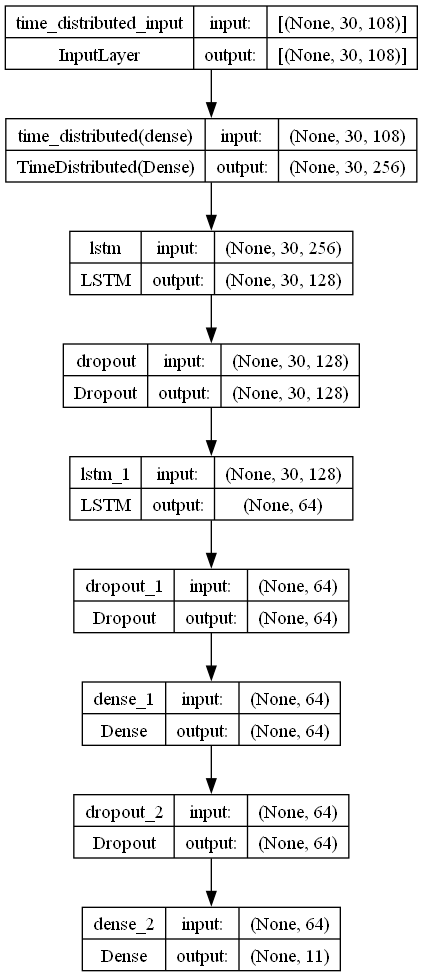

In [17]:
plot_model(model, to_file="model1.png", show_shapes=True)

In [18]:
model.load_weights('model-bimbingan.h5')

In [19]:
from scipy import stats

In [20]:
colors = [
    (245, 117, 16),  # Orange
    (117, 245, 16),  # Lime Green
    (16, 117, 245),  # Bright Blue
    (245, 16, 117),  # Pink
    (16, 245, 117),  # Teal
    (117, 16, 245),  # Purple
    (245, 245, 16),   # Yellow
    (128, 0, 128),   # Purple
    (255, 192, 203), # Light Pink
    (0, 255, 255),   # Cyan
    (255, 165, 0),   # Orange4
    # (128, 128, 128)  # Gray
]

def prob_viz(res, actions, input_frame, colors, frame_height=480, frame_width=640, opacity=0.4):
    output_frame = input_frame.copy()

    num_actions = len(actions)

    space_height = 4
    total_space_height = (num_actions + 1) * space_height

    bar_height = (frame_height - total_space_height) // num_actions

    font_scale = max(0.4, bar_height / 25)
    font_thickness = max(1, int(font_scale * 1.5))

    for num, prob in enumerate(res):
        bar_top = space_height + num * (bar_height + space_height)
        bar_bottom = bar_top + bar_height

        # Create an overlay for the semi-transparent rectangle
        overlay = output_frame.copy()
        cv.rectangle(overlay, (0, bar_top), (int(prob * frame_width), bar_bottom), colors[num], -1)

        # Blend the overlay with the original frame
        cv.addWeighted(overlay, opacity, output_frame, 1 - opacity, 0, output_frame)

        # Draw the text
        cv.putText(output_frame, actions[num], (10, bar_bottom - space_height // 2), cv.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), font_thickness, cv.LINE_AA)

    return output_frame


In [21]:
# sequence = []
# sentence = []
# predictions = []
# threshold = 0.5 

# cap = cv.VideoCapture(0)
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#     while cap.isOpened():

#         ret, frame = cap.read()

#         image, results = media_pipe_detection(frame, holistic)
        
#         draw_styled_handmarks(image, results)

#         keypoints = extract_keypoints_normalize(results)

#         sequence.append(keypoints)
#         sequence = sequence[-30:]
        
#         if len(sequence) == 30:
#             res = model.predict(np.expand_dims(sequence, axis=0))[0]
#             print(res)
#             print(actions[np.argmax(res)])
#             predictions.append(np.argmax(res))
            
#             if np.unique(predictions[-10:])[0]==np.argmax(res): 
#                 if res[np.argmax(res)] > threshold: 
                    
#                     if len(sentence) > 0: 
#                         if actions[np.argmax(res)] != sentence[-1]:
#                             sentence.append(actions[np.argmax(res)])
#                     else:
#                         sentence.append(actions[np.argmax(res)])

#             if len(sentence) > 5: 
#                 sentence = sentence[-5:]
                
#             image = prob_viz(res, actions, image, colors)
            
#         # cv.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
#         # cv.putText(image, ' '.join(sentence), (3,30), 
#         #                cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv.LINE_AA)
        
#         cv.imshow('OpenCV Feed', image)

#         if cv.waitKey(10) & 0xFF == ord('q'):
#             break
#     cap.release()
#     cv.destroyAllWindows()  

sequence = []
sentence = []
predictions = []
threshold = 0.5 

cap = cv.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = media_pipe_detection(frame, holistic)
        draw_styled_handmarks(image, results)

        keypoints = extract_keypoints_normalize(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            sequence_array = np.array(sequence)
            if sequence_array.shape == (30, 108):
                res = model.predict(np.expand_dims(sequence_array, axis=0))[0]
                print(actions[np.argmax(res)])
                predictions.append(np.argmax(res))
                
                if np.unique(predictions[-10:])[0] == np.argmax(res):
                    if res[np.argmax(res)] > threshold:
                        if len(sentence) > 0: 
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])

                if len(sentence) > 5: 
                    sentence = sentence[-5:]
                
                image = prob_viz(res, actions, image, colors)
        
        cv.imshow('OpenCV Feed', image)

        if cv.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv.destroyAllWindows()


1/1 [==============================] - 1s 541ms/step
standby
1/1 [==============================] - 0s 17ms/step
standby
1/1 [==============================] - 0s 18ms/step
standby
1/1 [==============================] - 0s 18ms/step
standby
1/1 [==============================] - 0s 17ms/step
standby
1/1 [==============================] - 0s 20ms/step
standby
1/1 [==============================] - 0s 19ms/step
standby
1/1 [==============================] - 0s 13ms/step
standby
1/1 [==============================] - 0s 18ms/step
standby
1/1 [==============================] - 0s 18ms/step
standby
1/1 [==============================] - 0s 19ms/step
standby
1/1 [==============================] - 0s 17ms/step
standby
1/1 [==============================] - 0s 20ms/step
standby
1/1 [==============================] - 0s 21ms/step
standby
1/1 [==============================] - 0s 18ms/step
standby
1/1 [==============================] - 0s 17ms/step
standby
1/1 [==============================] - 